In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Brain Tumor Detection Model using CNN LeNet architecture.

So In this project I am trying to classify MRI images as:
* Does the Image contain Tumor Like patterns or Not?

<br>
<h3>I am using a relatively small Dataset just trying to make it efficient by training the model on Less than 150 MRI Images by applying various Data augmentation and model creating techniques</h3>

<h4>I split the data into training, validation and testing before using it. But If anyone wants to download the Raw dataset, then you can check the below link: </h4>
<br>
<a href="https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection">https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection</a>

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import pandas as pd
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [17]:
train_data = 'drive/MyDrive/brain_tumor_dataset/train_data'
valid_data = 'drive/MyDrive/brain_tumor_dataset/valid_data'
test_data = 'drive/MyDrive/brain_tumor_dataset/test_data'

train_csv = 'drive/MyDrive/brain_tumor_dataset/train_data.csv'
valid_csv = 'drive/MyDrive/brain_tumor_dataset/valid_data.csv'
test_csv = 'drive/MyDrive/brain_tumor_dataset/test_data.csv'

In [18]:
# Data augmentation and normalization
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((32, 32)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ColorJitter(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [19]:
# Custom Dataset class
class Dataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.data_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.data_frame.iloc[idx, 1])
        image = Image.open(img_name).convert('RGB')
        label = int(self.data_frame.iloc[idx, 0])

        if self.transform:
            image = self.transform(image)

        return image, label

In [20]:
# Load datasets
train_dataset = Dataset(csv_file=train_csv, root_dir=train_data, transform=data_transforms['train'])
val_dataset = Dataset(csv_file=valid_csv, root_dir=valid_data, transform=data_transforms['val'])
test_dataset = Dataset(csv_file=test_csv, root_dir=test_data, transform=data_transforms['val'])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [21]:
# Define the LeNet model
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [22]:
model = LeNet()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [23]:
# loss, optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [24]:
# training & validation loss, training & validation accuracy
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# Training model
num_epochs = 2
best_acc = 0.0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        _, preds = torch.max(outputs, 1)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = running_corrects.double() / len(train_dataset)

    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc.cpu().numpy())

    print(f'Epoch {epoch}/{num_epochs - 1}')
    print(f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    model.eval()
    val_loss = 0.0
    val_corrects = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)

            val_loss += loss.item() * inputs.size(0)
            val_corrects += torch.sum(preds == labels.data)

    val_loss = val_loss / len(val_dataset)
    val_acc = val_corrects.double() / len(val_dataset)

    val_losses.append(val_loss)
    val_accuracies.append(val_acc.cpu().numpy())

    print(f'Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}')

    if val_acc > best_acc:
        best_acc = val_acc
        best_model_wts = model.state_dict()

Epoch 0/1
Train Loss: 0.6885 Acc: 0.5105
Val Loss: 0.6631 Acc: 0.5000
Epoch 1/1
Train Loss: 0.6554 Acc: 0.6364
Val Loss: 0.5951 Acc: 0.6250


In [25]:
# Load best model weights
model.load_state_dict(best_model_wts)

<All keys matched successfully>

In [26]:
# Evaluate on test dataset
model.eval()
test_loss = 0.0
test_corrects = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        _, preds = torch.max(outputs, 1)

        test_loss += loss.item() * inputs.size(0)
        test_corrects += torch.sum(preds == labels.data)

test_loss = test_loss / len(test_dataset)
test_acc = test_corrects.double() / len(test_dataset)

print(f'Test Loss: {test_loss:.4f} Acc: {test_acc:.4f}')

Test Loss: 0.6091 Acc: 0.7500


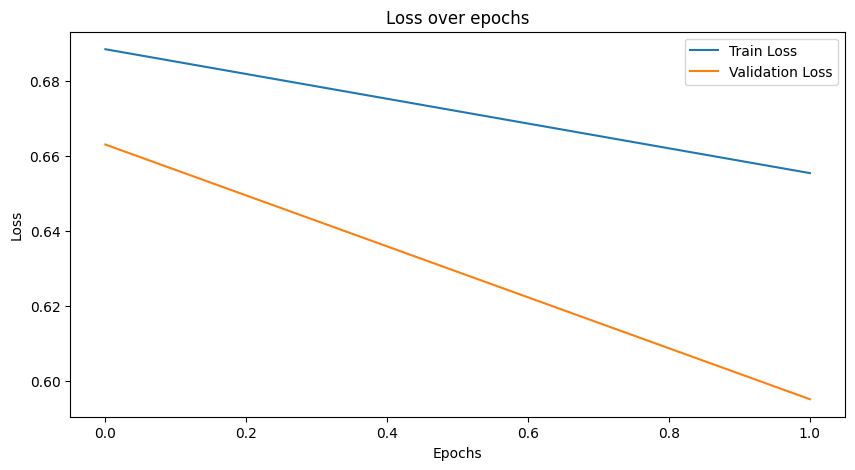

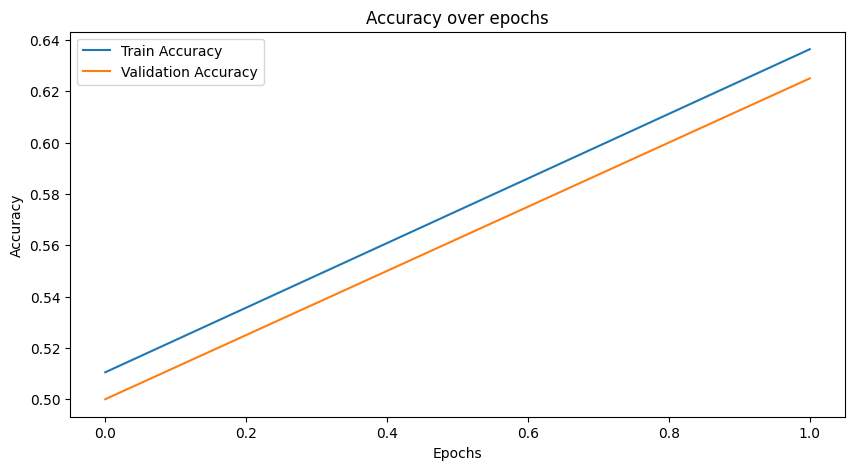

In [27]:
# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


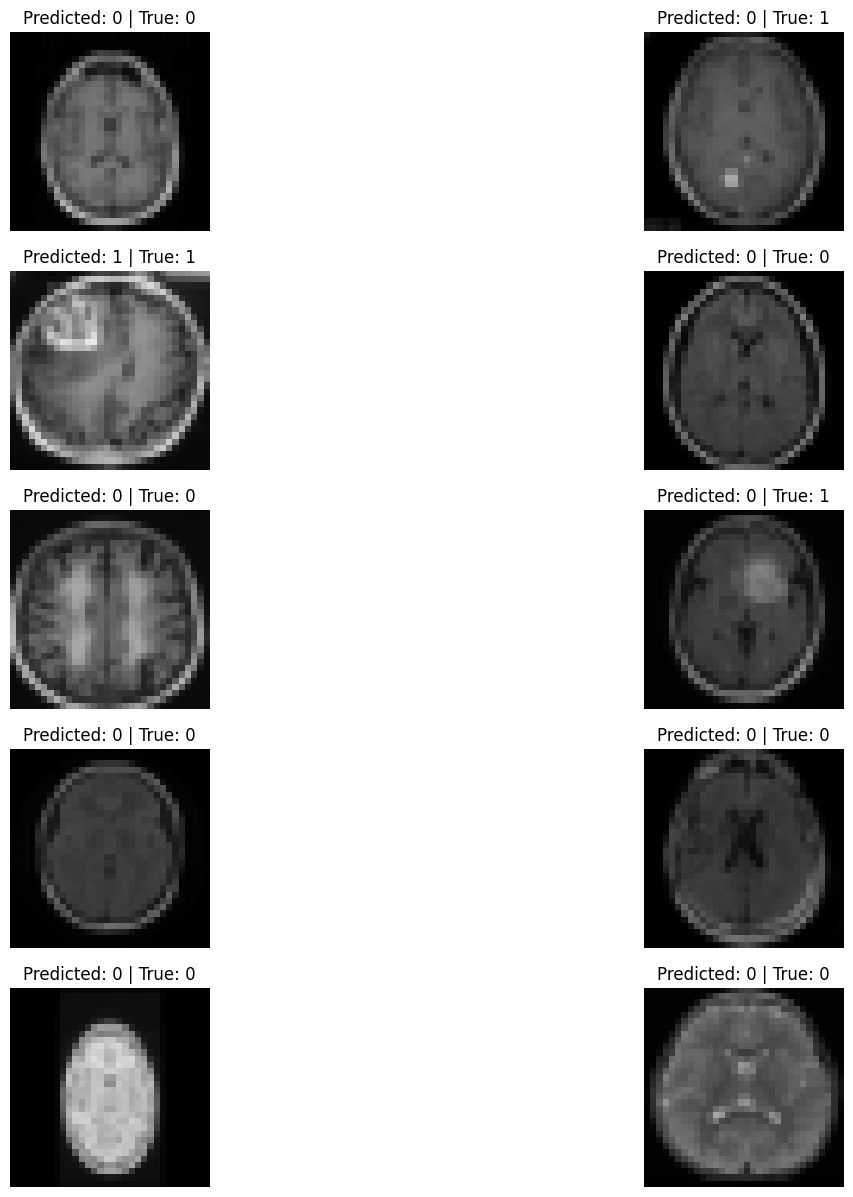

In [28]:
def predict_and_display(model, test_loader, device, num_images=10):
    model.eval()
    images_so_far = 0

    fig = plt.figure(figsize=(15, 15))

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'Predicted: {preds[j].item()} | True: {labels[j].item()}')
                img = inputs.cpu().data[j].numpy().transpose((1, 2, 0))
                img = np.clip(img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406], 0, 1)
                ax.imshow(img)

                if images_so_far == num_images:
                    return

predict_and_display(model, test_loader, device, num_images=10)


In [ ]:
# Save the best model weights
torch.save(model.state_dict(), 'BTD_model.pth')